###### ### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2021 Semester 1

## Assignment 1: Pose classification with naive Bayes


**Student ID(s):**     `PLEASE ENTER YOUR ID(S) HERE`


This iPython notebook is a template which you will use for your Assignment 1 submission.

Marking will be applied on the four functions that are defined in this notebook, and to your responses to the questions at the end of this notebook (Submitted in a separate PDF file).

**NOTE: YOU SHOULD ADD YOUR RESULTS, DIAGRAMS AND IMAGES FROM YOUR OBSERVATIONS IN THIS FILE TO YOUR REPORT (the PDF file).**

You may change the prototypes of these functions, and you may write other functions, according to your requirements. We would appreciate it if the required functions were prominent/easy to find.

**Adding proper comments to your code is MANDATORY. **

In [16]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import copy
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from scipy.stats import norm

# This function should prepare the data by reading it from a file and converting it into a useful format for training and testing

def preprocess(file_location):
    df = pd.read_csv(file_location, header=None, index_col=0)
    ### drop missing values when training
    df.replace(9999,np.nan, inplace = True)
    df_new = df.dropna(how = 'all')   ### drop instance with all NaN
    df_new = df_new.reset_index()
    df_new.columns = ['class','x1','x2','x3', 'x4', 'x5', 'x6', 'x7','x8','x9','x10','x11','y1','y2','y3', 'y4', 'y5', 'y6', 'y7','y8','y9','y10','y11']
    print('File has been preprocessed.')
    return df_new

In [17]:
# This function should calculat prior probabilities and likelihoods from the training data and using
# them to build a naive Bayes model

### frequency mean and std of each class
def train(train_set):
    label = train_set['class']
    dict_info = {}
    for each_class in set(label):     ###dict stores prior probability & mean $ std
        dict_info[each_class] = []
        data = train_set.loc[train_set['class'] == each_class]
        dict_info[each_class].append(data.count()[0]/train_set.shape[0])  ### prior prob of this class
        dict_info[each_class].append(data.mean())  ### mean of each feature of this class
        dict_info[each_class].append(data.std())  ### unbiased std of each feature of this class
    return dict_info

In [18]:
# This function should predict classes for new items in a test dataset (for the purposes of this assignment, you
# can re-use the training data as a test set)

def predict(train_info, test_location, smalllog):
    ### preprocess the teating file
    test  = pd.read_csv(test_location)
    test.replace(9999,np.nan, inplace = True)
    test.columns = ['class','x1','x2','x3', 'x4', 'x5', 'x6', 'x7','x8','x9','x10','x11','y1','y2','y3', 'y4', 'y5', 'y6', 'y7','y8','y9','y10','y11']
    label = train_info.keys()
    pred = {}
    for each in test.iterrows():   ### predict each test data
        prob = {}
        for each_label in label:   ### calculate prob of oberving this instance given it belongs to each class 
            prob[each_label] = math.log(train_info[each_label][0]) ## prior probability
            for attribute in test.columns[1:]:
                if math.isnan(each[1][attribute])== False:   ### ignore missing values
                    likelihood = norm.pdf(each[1][attribute],train_info[each_label][1][attribute], train_info[each_label][2][attribute])    ### calculate likelihood 
                    if likelihood>0:     ###replace log(0) with a large negative value 
                        prob[each_label] += math.log(likelihood)
                    else:
                        prob[each_label] += smalllog  ## smoothing method
        prob = sorted(prob.items(),key=lambda x:x[1],reverse=True)  ### choose the largest log value
        pred[each[0]] = [prob[0][0], each[1][0]]   ### prediction & true class
    return pred

In [19]:
# This function should evaliate the prediction performance by comparing your model’s class outputs to ground
# truth labels

### evaluation state
### acuracy
def evaluate(pred):
    true = 0
    for output in pred.items():
        if output[1][0] == output[1][1]:
            true += 1
    print('Naive bayes accuracy is', true/len(pred.keys()))
    return true/len(pred.keys())

## Questions 


If you are in a group of 1, you will respond to **two** questions of your choosing.

If you are in a group of 2, you will respond to **four** questions of your choosing.

A response to a question should take about 100–250 words, and make reference to the data wherever possible.

#### NOTE: you may develope codes or functions to help respond to the question here, but your formal answer should be submitted separately as a PDF.

### Q1
Since this is a multiclass classification problem, there are multiple ways to compute precision, recall, and F-score for this classifier. Implement at least two of the methods from the "Model Evaluation" lecture and discuss any differences between them. (The implementation should be your own and should not just call a pre-existing function.)

In [20]:
### Question 1 --- Micro vs. Macro

### return confusion matrix of each class
def predictionTable(pred, test_location):
    test = pd.read_csv(test_location, header=None)
    test.columns = ['class','x1','x2','x3', 'x4', 'x5', 'x6', 'x7','x8','x9','x10','x11','y1','y2','y3', 'y4', 'y5', 'y6', 'y7','y8','y9','y10','y11']
    label = test['class']
    ### big dictionary stores all true class label names
    table = {}
    prediction = {}
    for each_class in label:   ### prediction value
        prediction[each_class] = 0
    for each_class in label:   ### actual value
        table[each_class] = copy.deepcopy(prediction)
    for each in pred.items():
        table[each[1][1]][each[1][0]]+=1  
    table = pd.DataFrame.from_dict(table, orient='index')
    return table

def macroEvaluation(table):
    precision_arr = []
    recall_arr = []
    macro = {}
    table_T=table.T  ###transpose to calculate sum of rows--actual number of elements in each class
    for label in table._stat_axis.values.tolist():
        TP = table.loc[label][label]
        FP = table.sum()[label]-TP
        FN = table_T.sum()[label]-TP
        precision_arr.append(TP/(TP+FP))
        recall_arr.append(TP/(TP+FN))
    macro['precision']=np.mean(precision_arr)
    macro['recall']=np.mean(recall_arr)
    ###two possible ways to implement macro-F
    macro['F']=2*np.mean(precision_arr)*np.mean(recall_arr)/(np.mean(recall_arr)+np.mean(precision_arr)) 
    print('Macro-precision is:', macro['precision'])
    print('Macro-recall is:', macro['recall'])
    print('Macro-F-score is:', macro['F'])
    return macro

def microEvaluation(table):
    TP_arr = []
    FP_arr = []
    FN_arr = []
    micro = {}
    table_T=table.T  ###transpose to calculate sum of rows--actual number of elements in each class
    for label in table._stat_axis.values.tolist():
        TP_arr.append(table.loc[label][label])
        FP_arr.append(table.sum()[label]-table.loc[label][label])
        FN_arr.append(table_T.sum()[label]-table.loc[label][label])
    micro['precision']=np.sum(TP_arr)/(np.sum(TP_arr)+np.sum(FP_arr))
    micro['recall']=np.sum(TP_arr)/(np.sum(TP_arr)+np.sum(FN_arr))
    micro['F']=2*micro['precision']*micro['recall']/(micro['recall']+micro['precision'])
    print('Micro-precision is:', micro['precision'])
    print('Micro-recall is:', micro['recall'])
    print('Micro-F-score is:', micro['F'])
    return micro



### Q2
The Gaussian naıve Bayes classifier assumes that numeric attributes come from a Gaussian distribution. Is this assumption always true for the numeric attributes in this dataset? Identify some cases where the Gaussian assumption is violated and describe any evidence (or lack thereof) that this has some effect on the classifier’s predictions.

### Q3
Implement a kernel density estimate (KDE) naive Bayes classifier and compare its performance to the Gaussian naive Bayes classifier. Recall that KDE has kernel bandwidth as a free parameter -- you can choose an arbitrary value for this, but a value in the range 5-25 is recommended. Discuss any differences you observe between the Gaussian and KDE naive Bayes classifiers. (As with the Gaussian naive Bayes, this KDE naive Bayes implementation should be your own and should not just call a pre-existing function.)

Text(0.5, 1.0, 'Gaussian vs KDE with sigma 10 for bridge x1')

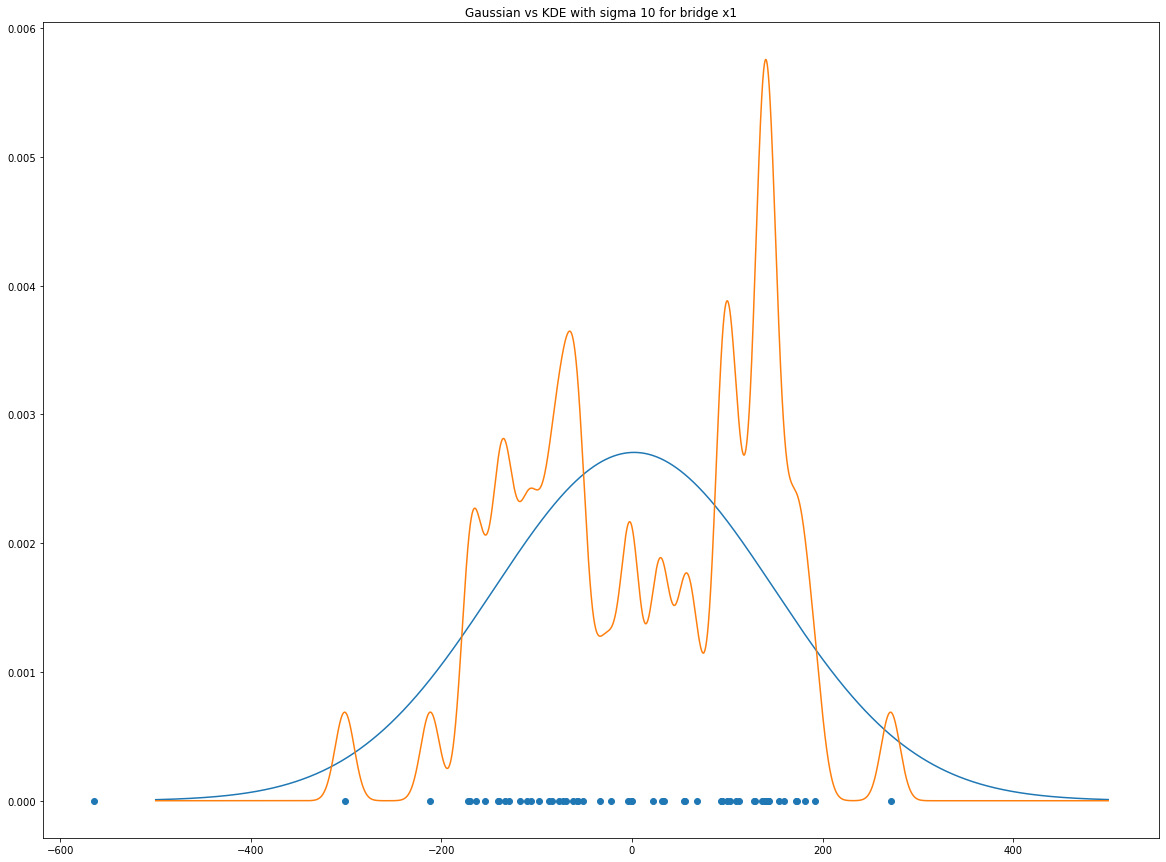

In [21]:
### Question 5
### KDE naive Bayes Classifier ###
### generate probability density of each attribute in each class + prior probability 
def train_KDE(train_set):
    label = train_set['class']
    dict_info = {}  
    for each_class in set(label):     ###dict stores prior probability
        dict_info[each_class] = {}
        data = train_set.loc[train_set['class'] == each_class] ### all data with the same class
        dict_info[each_class]['prior']=(data.count()[0]/train_set.shape[0])  ### prior prob of this class
        for feature in train_set.columns[1:]:   ### get each feature's density function based on centered Gaussian
            dict_info[each_class][feature]=data[feature]
    return dict_info

def density_KDE(data, sigma, instance):
    density = sum(norm.pdf(instance, loc=xi, scale=sigma) for xi in data if math.isnan(xi)==False)/data.count()
    return density  ### calculate density of given instance in KDE prob

def predict_KDE(train_info, test_location, sigma, smalllog):
    ### preprocess the testing file
    test  = pd.read_csv(test_location)
    test.replace(9999,np.nan, inplace = True)
    test.columns = ['class','x1','x2','x3', 'x4', 'x5', 'x6', 'x7','x8','x9','x10','x11','y1','y2','y3', 'y4', 'y5', 'y6', 'y7','y8','y9','y10','y11']
    label = train_info.keys()
    pred = {}
    for each in test.iterrows():   ### predict each test data
        prob = {}
        for each_label in label:   ### calculate prob of oberving this instance given it belongs to each class 
            prob[each_label] = math.log(train_info[each_label]['prior']) ## prior probability
            for attribute in test.columns[1:]:
                if math.isnan(each[1][attribute])== False:   ### ignore missing values
                    likelihood = density_KDE(train_info[each_label][attribute], sigma, each[1][attribute])    ### calculate likelihood 
                    if likelihood>0:     ###replace log(0) with a large negative value 
                        prob[each_label] += math.log(likelihood)
                    else:
                        prob[each_label] += smalllog  ### smoothing method
        prob = sorted(prob.items(),key=lambda x:x[1],reverse=True)  ### choose the largest log value
        pred[each[0]] = [prob[0][0], each[1][0]]   ### prediction & true class
    return pred


#### visualize KDE and Gaussian ####
### Gaussian bridge-x1
def normfun(x, mu, sigma):
    pdf = np.exp(-((x - mu)**2)/(2*sigma**2)) / (sigma * np.sqrt(2*np.pi))
    return pdf
data = pd.Series((train_set[train_set['class']=='bridge']['x1']).values).tolist()
y = []
for i in data:
    y.append(0)
x = np.arange(-500, 500, 0.1)
y1 = normfun(x, train_info['bridge'][1]['x1'], train_info['bridge'][2]['x1'])
y2=0
count = 0
for each in data:
    if math.isnan(each) != True:
        count+=1
        y2 += normfun(x,each,10)
y2 = y2/count
plt.figure(figsize=(20,15))
plt.plot(x, y1)
plt.plot(x, y2)
plt.scatter(data, y)
plt.title('Gaussian vs KDE with sigma 10 for bridge x1')

### Q4
Instead of using an arbitrary kernel bandwidth for the KDE naive Bayes classifier, use random hold-out or cross-validation to choose the kernel bandwidth. Discuss how this changes the model performance compared to using an arbitrary kernel bandwidth.

### Q5
Naive Bayes ignores missing values, but in pose recognition tasks the missing values can be informative. Missing values indicate that some part of the body was obscured and sometimes this is relevant to the pose (e.g., holding one hand behind the back). Are missing values useful for this task? Implement a method that incorporates information about missing values and demonstrate whether it changes the classification results.

### Q6
Engineer your own pose features from the provided keypoints. Instead of using the (x,y) positions of keypoints, you might consider the angles of the limbs or body, or the distances between pairs of keypoints. How does a naive Bayes classifier based on your engineered features compare to the classifier using (x,y) values? Please note that we are interested in explainable features for pose recognition, so simply putting the (x,y) values in a neural network or similar to get an arbitrary embedding will not receive full credit for this question. You should be able to explain the rationale behind your proposed features. Also, don't forget the conditional independence assumption of naive Bayes when proposing new features -- a large set of highly-correlated features may not work well.

In [22]:
train_set = preprocess('C:/Users/Ivy/Desktop/ML/asmt1/train.csv')
train_info = train(train_set)
pred = predict(train_info, 'C:/Users/Ivy/Desktop/ML/asmt1/test.csv', -50)
acc = evaluate(pred)

File has been preprocessed.
Naive bayes accuracy is 0.7304347826086957


In [25]:
train_set = preprocess('C:/Users/Ivy/Desktop/ML/asmt1/train.csv')
train_info_KDE = train_KDE(train_set)
pred_KDE = predict_KDE(train_info_KDE, 'C:/Users/Ivy/Desktop/ML/asmt1/test.csv', 10, -50)
acc = evaluate(pred_KDE)

File has been preprocessed.
Naive bayes accuracy is 0.7739130434782608


In [27]:
table = predictionTable(pred, 'C:/Users/Ivy/Desktop/ML/asmt1/test.csv')
macroEvaluation(table)
microEvaluation(table)
#### Generate Confusion Matrix ####
print('Below is the confusion matrix')
table

Macro-precision is: 0.7664005602240895
Macro-recall is: 0.7615170940170939
Macro-F-score is: 0.7639510229558422
Micro-precision is: 0.7739130434782608
Micro-recall is: 0.7739130434782608
Micro-F-score is: 0.7739130434782608
Below is the confusion matrix


,bridge,childs,downwarddog,mountain,plank,seatedforwardbend,tree,trianglepose,warrior1,warrior2
bridge,8,1,1,0,3,0,0,0,0,0
childs,0,10,1,1,0,1,0,0,0,0
downwarddog,1,0,14,3,0,0,0,0,0,0
mountain,0,0,0,26,0,0,4,0,0,0
plank,1,0,0,0,7,0,0,0,1,0
seatedforwardbend,0,1,1,0,1,6,0,0,0,0
tree,0,0,0,0,0,0,4,0,2,0
trianglepose,0,0,0,0,0,0,0,4,0,0
warrior1,0,0,0,0,1,0,1,0,3,0
warrior2,0,0,0,0,0,0,1,0,0,7
